In [1]:
import os
import json
import pickle

import torch
import numpy as np
import recmetrics as rm
import scipy.sparse as sp
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

import pandas as pd
pd.set_option('display.max_columns', None)


from matplotlib import pyplot as plt

import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)


import sys 
sys.path.append('..')

from src.model.pmf import PMF

In [2]:
dataset_path = "../data/movie_lens_1m_output_path.json"
with open(dataset_path) as json_file:
    _dataset_path = json.load(json_file)

dataset = {}
with open(os.path.join("..", _dataset_path["train_users_dict"]), "rb") as pkl_file:
    dataset["train_users_dict"] = pickle.load(pkl_file)

with open(os.path.join("..", _dataset_path["train_users_history_lens"]), "rb") as pkl_file:
    dataset["train_users_history_lens"] = pickle.load(pkl_file)

with open(os.path.join("..", _dataset_path["eval_users_dict"]), "rb") as pkl_file:
    dataset["eval_users_dict"] = pickle.load(pkl_file)

with open(os.path.join("..", _dataset_path["eval_users_history_lens"]), "rb") as pkl_file:
    dataset["eval_users_history_lens"] = pickle.load(pkl_file)

with open(os.path.join("..", _dataset_path["users_history_lens"]), "rb") as pkl_file:
    dataset["users_history_lens"] = pickle.load(pkl_file)

with open(os.path.join("..", _dataset_path["item_groups"]), "rb") as pkl_file:
    dataset["item_groups"] = pickle.load(pkl_file)

items_df = pd.read_csv(_dataset_path["items_df"])
users_df = pd.read_csv(_dataset_path["users_df"])
ratings_df = pd.read_csv(_dataset_path["ratings_df"])

In [3]:
fig = px.histogram(list(dataset["item_groups"].values()))
fig.update_layout(
    xaxis_title = "Groups",
    yaxis_title = "Items",
)
fig.show()

In [4]:
# reward_model = PMF(943, 1682, 50).to("cuda")
# reward_model.load_state_dict(
#     torch.load(
#         "../model/pmf/emb_50_ratio_0.800000_bs_1000_e_258_wd_0.100000_lr_0.000100_trained_pmf.pt",
#         map_location=torch.device("cuda"),
#     )
# )

reward_model = PMF(6040, 3883, 100).to("cuda")
reward_model.load_state_dict(
    torch.load(
        "../model/pmf/ml_1m_emb_100_ratio_0.800000_bs_1000_e_457_wd_0.100000_lr_0.000100_trained_pmf.pt",
        map_location=torch.device("cuda"),
    )
)

user_embeddings = reward_model.user_embeddings.weight.data
item_embeddings = reward_model.item_embeddings.weight.data

In [5]:
item_groups_df = pd.DataFrame(dataset["item_groups"].items(), columns=["item_id", "group"])
feature_df = pd.DataFrame(item_groups_df[["item_id"]].apply(lambda x: item_embeddings[x].cpu().numpy().tolist())["item_id"].tolist())

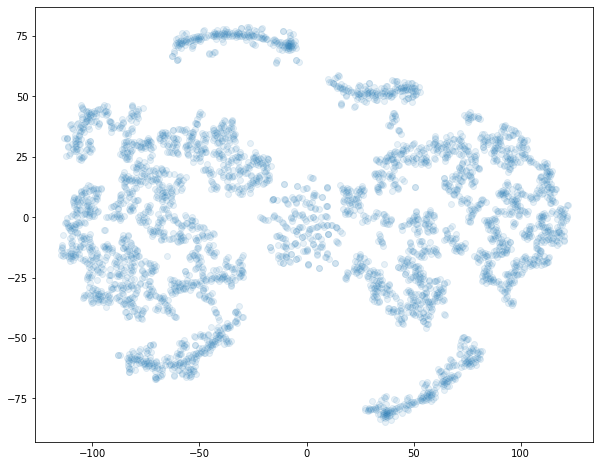

In [6]:
# The default of 1,000 iterations gives fine results, but I'm training for longer just to eke
# out some marginal improvements. NB: This takes almost an hour!
tsne = TSNE(random_state=1, n_iter=15000, metric="cosine")

embs = tsne.fit_transform(feature_df.values)
# Add to dataframe for convenience
item_groups_df['x'] = embs[:, 0]
item_groups_df['y'] = embs[:, 1]

FS = (10, 8)
fig, ax = plt.subplots(figsize=FS)
fig.patch.set_facecolor("white")
# Make points translucent so we can visually identify regions with a high density of overlapping points
ax.scatter(item_groups_df.x, item_groups_df.y, alpha=.1)

In [7]:
def plot_bg(bg_alpha=.01, figsize=(13, 9), emb_2d=None):
    """Create and return a plot of all our movie embeddings with very low opacity.
    (Intended to be used as a basis for further - more prominent - plotting of a 
    subset of movies. Having the overall shape of the map space in the background is
    useful for context.)
    """
    if emb_2d is None:
        emb_2d = embs
    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_facecolor("white")
    X = emb_2d[:, 0]
    Y = emb_2d[:, 1]
    ax.scatter(X, Y, alpha=bg_alpha)
    return ax
    
def plot_with_annotations(label_indices, text=True, labels=None, alpha=1, **kwargs):
    ax = plot_bg(**kwargs)
    Xlabeled = embs[label_indices, 0]
    Ylabeled = embs[label_indices, 1]
    if labels is not None:
        for x, y, label in zip(Xlabeled, Ylabeled, labels):
            ax.scatter(x, y, alpha=alpha, label=label, marker='1',
                       s=90,
                      )
        fig.legend()
    else:
        ax.scatter(Xlabeled, Ylabeled, alpha=alpha, color='green')
    
    
    return ax

<AxesSubplot:>

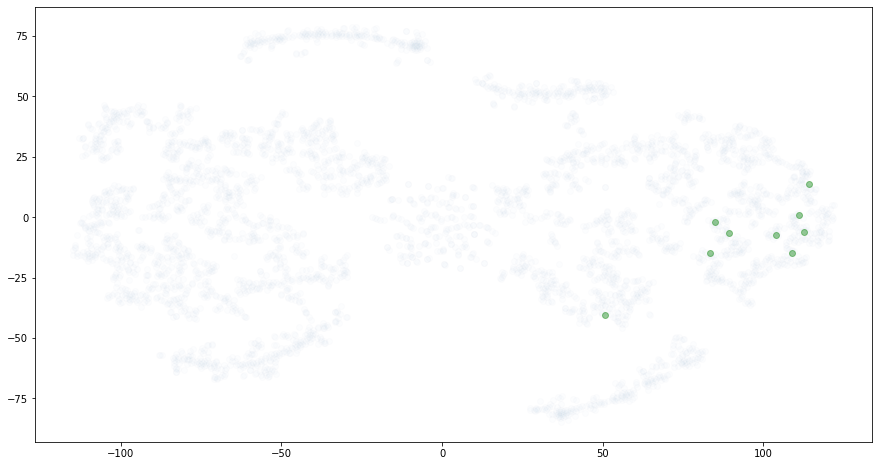

In [8]:
plot_with_annotations(items_df[items_df["title"].str.startswith('Star Trek')].index, text=False, alpha=.4, figsize=(15, 8))

In [9]:
ratings_df = ratings_df[ratings_df["rating"] > 3]
users = ratings_df.groupby("user_id").agg({"movie_id": lambda x: x.tolist()}).reset_index()
users

,user_id,movie_id
0,0,"[1176, 3339, 2286, 1267, 2735, 590, 907, 591, ..."
1,1,"[1336, 2999, 1499, 2125, 642, 2199, 3399, 1192..."
2,2,"[3352, 1373, 102, 2666, 1192, 1063, 1573, 1271..."
3,3,"[3399, 2882, 1196, 1023, 257, 1959, 476, 1180,..."
4,4,"[2918, 2264, 1159, 2268, 1498, 1371, 855, 2701..."
...,...,...
6033,6035,"[585, 2937, 2939, 1995, 2000, 586, 589, 590, 5..."
6034,6036,"[2937, 1995, 589, 891, 892, 896, 897, 898, 900..."
6035,6037,"[1395, 3019, 229, 1120, 1132, 1166, 2077, 3479..."
6036,6038,"[584, 1998, 1393, 2953, 2011, 2966, 2968, 889,..."


In [10]:
def _single_list_similarity(predicted, feature_df):
    recs_content = feature_df.loc[predicted]
    recs_content = recs_content.values
    similarity = cosine_similarity(X=recs_content, dense_output=False)

    # #get indicies for upper right triangle w/o diagonal
    upper_right = np.triu_indices(similarity.shape[0], k=1)
    upper_right

    # #calculate average similarity score of all recommended items in list
    ils_single_user = np.mean(similarity[upper_right])
    return ils_single_user

In [11]:
users["similarity"] = users["movie_id"].apply(lambda x: _single_list_similarity(x, feature_df))
users

/home/luana/data/miniconda3/envs/rsrl/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning:

Mean of empty slice.



,user_id,movie_id,similarity
0,0,"[1176, 3339, 2286, 1267, 2735, 590, 907, 591, ...",0.063981
1,1,"[1336, 2999, 1499, 2125, 642, 2199, 3399, 1192...",-0.004891
2,2,"[3352, 1373, 102, 2666, 1192, 1063, 1573, 1271...",0.033017
3,3,"[3399, 2882, 1196, 1023, 257, 1959, 476, 1180,...",-0.045754
4,4,"[2918, 2264, 1159, 2268, 1498, 1371, 855, 2701...",0.679858
...,...,...,...
6033,6035,"[585, 2937, 2939, 1995, 2000, 586, 589, 590, 5...",0.506581
6034,6036,"[2937, 1995, 589, 891, 892, 896, 897, 898, 900...",0.454766
6035,6037,"[1395, 3019, 229, 1120, 1132, 1166, 2077, 3479...",0.077705
6036,6038,"[584, 1998, 1393, 2953, 2011, 2966, 2968, 889,...",0.366297


In [12]:
_single_list_similarity(items_df[items_df["title"].str.startswith('Star Trek')].movie_id.values, feature_df)

0.9985074453009852

In [13]:
px.bar(users, x="user_id", y="similarity", title="Similarity of User Positive Ratings")

In [14]:
px.histogram(users, x="similarity", title="Similarity of User Positive Ratings")

In [15]:
users.similarity.describe()

count    6037.000000
mean        0.187171
std         0.231855
min        -0.332375
25%         0.009271
50%         0.102358
75%         0.300519
max         0.999471
Name: similarity, dtype: float64

In [16]:
users[users["similarity"]> 0.4]

,user_id,movie_id,similarity
4,4,"[2918, 2264, 1159, 2268, 1498, 1371, 855, 2701...",0.679858
11,11,"[1176, 1180, 589, 3827, 2735, 907, 911, 847, 3...",0.472586
26,26,"[1228, 1230, 1232, 1164, 1234, 2928, 3366, 329...",0.663350
34,34,"[3290, 1231, 1232, 1168, 2639, 3296, 1767, 152...",0.615213
46,46,"[1176, 315, 246, 2735, 890, 1880, 16, 1887, 84...",0.555929
...,...,...,...
6029,6031,"[0, 590, 592, 2016, 2018, 2968, 888, 890, 2027...",0.677271
6031,6033,"[901, 930, 3366, 1163, 2117, 1228, 1232, 1240,...",0.995547
6033,6035,"[585, 2937, 2939, 1995, 2000, 586, 589, 590, 5...",0.506581
6034,6036,"[2937, 1995, 589, 891, 892, 896, 897, 898, 900...",0.454766
